<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

## Objective
* Utilize a CNN to recolorize a greyscale image
* Attempt a GAN for Superresolution


In [1]:
!nvidia-smi

Tue Apr  6 09:06:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
import pdb
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from statistics import mean
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import torchvision.utils as vutils
import os
import gzip
import tarfile
import gc
from skimage import io, color
from IPython.core.ultratb import AutoFormattedTB

#assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

from google.colab import drive
drive.mount('/content/drive')
data_directory = '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/sub/Coco_sub/'

Mounted at /content/drive


In [ ]:
'''
#https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
import os
size = 256
# Reorganizing Images and renaming based on index
os.getcwd()
collection = '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/Coco_sub/'

for i, filename in enumerate(os.listdir(collection)):
    os.rename(collection + filename, collection + str(i) + ".jpg")
    #os.rename(collection + filename, collection + 'imgr' + str(i) + ".jpg")

dirs = os.walk(collection)
for i, filename in enumerate(os.listdir(collection)):
    name = os.path.join(collection, filename)
    if os.path.isfile(name):
        im = Image.open(name)
        im = ImageOps.fit(im, (size, size))
        #im.save(name[:-4] + '.jpg', 'JPEG')
        im.save(str(i) + '.jpg', 'JPEG')
        os.remove(name)
'''

'\n#https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8\nimport os\nsize = 256\n# Reorganizing Images and renaming based on index\nos.getcwd()\ncollection = \'/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/Coco_sub/\'\n\nfor i, filename in enumerate(os.listdir(collection)):\n    os.rename(collection + filename, collection + str(i) + ".jpg")\n    #os.rename(collection + filename, collection + \'imgr\' + str(i) + ".jpg")\n\ndirs = os.walk(collection)\nfor i, filename in enumerate(os.listdir(collection)):\n    name = os.path.join(collection, filename)\n    if os.path.isfile(name):\n        im = Image.open(name)\n        im = ImageOps.fit(im, (size, size))\n        #im.save(name[:-4] + \'.jpg\', \'JPEG\')\n        im.save(str(i) + \'.jpg\', \'JPEG\')\n        os.remove(name)\n'

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [2]:
from torchvision import transforms
import os

class LABDataset(Dataset):
  def __init__(self, root_dir, size = 256, transform=None):
    super(LABDataset, self).__init__()
    self.size = size
    self.root_dir = root_dir
    self.dataset = []
    self.preprocess()
  def __len__(self):
    return len(self.dataset)

  def preprocess(self):
    path, dirs, files = next(os.walk(self.root_dir))
    for i in range(len(files)):
      try:
        img_name = os.path.join(self.root_dir, str(files[i]))
        image = target = io.imread(img_name)
        image = image/255.0
        img_lab = color.rgb2lab(image)
        img_gray = img_lab [:,:,0]/100
        img_gray = torch.from_numpy(img_gray).unsqueeze(2).float()
        img_ab = img_lab[:,:,1:]/128
        img_ab = torch.from_numpy(img_ab)
        #test_plot(L_eval, y_ab, orig_eval)
        self.dataset.append((img_gray,img_ab, target))
      except Exception as e:
        print(e)
        continue
#plt.imshow(img_gray, cmap="gray")
#test = torch.cat((img_gray*100,img_ab*128),2)
#plt.imshow(color.lab2rgb(test))
  def __getitem__(self, i):
    return self.dataset[i]

In [4]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = LABDataset(root_dir=data_directory)
datasets = train_val_dataset(dataset)
torch.save(dataset, '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/LAB.data')
torch.save(datasets, '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/data_loader.data')

the input array must be have a shape == (.., ..,[ ..,] 3)), got (256, 256)
the input array must be have a shape == (.., ..,[ ..,] 3)), got (256, 256)


In [4]:
dataset = torch.load('/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/LAB.data', map_location=torch.device('cpu'))
datasets = torch.load('/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/data_loader.data', map_location=torch.device('cpu'))

In [3]:
#Plotting Functions
#CIE-LAB
from skimage.io import imsave

def sample_image_prep(L_eval, y_ab, orig_eval):
  L_eval = L_eval.unsqueeze(0)
  y_ab =y_ab.unsqueeze(0)
  orig_eval = torch.tensor(orig_eval).unsqueeze(0)
  return L_eval, y_ab, orig_eval

def test_plot(L_eval, y_ab, orig_eval):
  #Display Original Image
  plt.figure()
  plt.title('Original Image')
  plt.imshow(orig_eval)
  plt.show()

  # Plot Reconstructed Image
  test = torch.cat((L_eval*100, y_ab*128),2)
  plt.figure()
  plt.title('Image Reconstruction')
  plt.imshow(color.lab2rgb(test))
  plt.show()

  #Construct 
  L_eval = L_eval.squeeze(2)*100
  y_a = y_ab[:,:,0]
  y_b = y_ab[:,:,1]

  #Display L
  plt.figure()
  plt.title('Lightness')
  plt.imshow(L_eval, cmap="gray")
  plt.show()

  #Display a
  plt.figure()
  plt.title('CIE_LAB Green-Red')
  plt.imshow(y_a)
  plt.show()

  #Display b
  plt.figure()
  plt.title('CIE_LAB Blue-Yellow')
  plt.imshow(y_b)
  plt.show()

In [5]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Unet(nn.Module):
  def __init__(self):
    super(Unet, self).__init__()
    #NN.CONV2D(Channelin,Channel_Out, Kernel Size, Stride, Padding)

    ### Encode
    self.Conv01 = nn.Conv2d(1,64,kernel_size = 3, stride=(2,2), padding = (1,1))
    self.Conv02 = nn.Conv2d(64,128,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv03 = nn.Conv2d(128,128,kernel_size = 3, stride=(2,2),  padding=(1,1))
    self.Conv04 = nn.Conv2d(128,256,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv05 = nn.Conv2d(256,256,kernel_size = 3, stride=(2,2),  padding=(1,1))
    self.Conv06 = nn.Conv2d(256,512,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv07 = nn.Conv2d(512,512,kernel_size = 3, stride=(1,1),  padding=(1,1))

    ### Decode
    self.Conv08 = nn.Conv2d(512,256,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv09 = nn.Conv2d(256,128,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv10 = nn.Conv2d(128,64,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv11 = nn.Conv2d(64,32,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv12 = nn.Conv2d(32,16,kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv13 = nn.Conv2d(16,2,kernel_size = 1)
    ### Upsampling
    self.Upsample = nn.Upsample(scale_factor=2, mode='nearest')

  def forward(self, x):
    x = F.relu(self.Conv01(x))
    x = F.relu(self.Conv02(x))
    x = F.relu(self.Conv03(x))
    x = F.relu(self.Conv04(x))
    x = F.relu(self.Conv05(x))
    x = F.relu(self.Conv06(x))
    x = F.relu(self.Conv07(x))
    x = F.relu(self.Conv08(x))
    x = F.relu(self.Conv09(x))
    #pdb.set_trace()
    x = self.Upsample(x)
    x = F.relu(self.Conv10(x))
    x = self.Upsample(x)
    x = F.relu(self.Conv11(x))
    x = F.relu(self.Conv12(x))
    x = F.tanh(self.Conv13(x))
    x = self.Upsample(x)
    return x


In [49]:
def scope():
  try:
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    Total_epochs = 201
    train_dataset = datasets['train']
    val_dataset = datasets['val']
    #Batch = 5
    Batch = 10
    # Initialize DataLoaders
    train_loader = DataLoader(train_dataset,
                              num_workers=2, 
                              batch_size = Batch, 
                              pin_memory=True,
                              shuffle=True)
    validation_loader = DataLoader(val_dataset,
                                  num_workers=2, 
                                  batch_size=Batch,
                                  pin_memory=True)
    # Initialize Model
    # model = Unet()
    # model.apply(init_weights)
    model = torch.load('/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/colorization.model')
    model.cuda()
    # Memory Issue Solver
    gc.collect()
    # Initialize Objective and Optimizer and other parameters
    objective = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-4)
    losses_e = []
    train_accuracy_e = []
    validations_loss = []
    validation_iter_loss = []
    # Call your model, figure out loss and accuracy
    for epoch in range(Total_epochs):
      loop = tqdm(total = np.ceil(len(train_dataset)/Batch), position = 0, leave = False)
      losses = []
      train_accuracy = []
      for batch, (x, y_truth, original_image) in enumerate(train_loader):
        #pdb.set_trace()
        x = x.permute(0,3,1,2)
        y_truth = y_truth.permute(0,3,1,2)
        x, y_truth = x.cuda(), y_truth.cuda()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = objective(y_hat.float(), y_truth.float())
        loss.backward()
        mem = torch.cuda.memory_allocated(0)/1e9
        losses.append(loss.item())
        loop.set_description('epoch:{}, loss:{:.4f}, mem:{:.2f}'.format(epoch, loss.item(), mem))
        loop.update(1)
        optimizer.step()
        if batch % 100 == 0:
          model = model.eval()
          for x_val,y_val,_ in validation_loader:
            x_val = x_val.permute(0,3,1,2)
            y_val = y_val.permute(0,3,1,2)
            y_hat_val = model(x_val.cuda())
            loss_val = objective(y_hat_val, y_val.cuda().float()).item()
            validation_iter_loss.append(loss_val)
          model = model.train()
      #Training Loss
      losses_e.append(sum(losses)/len(losses))
      print('Training Loss is: ' + str(losses_e[epoch]))

      #Validation Loss
      validations_loss.append(sum(validation_iter_loss)/len(validation_iter_loss))
      print('Validation Loss is: ' + str(validations_loss[epoch]))
      torch.save(model, '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/colorization.model')
      loop.close()
      #Test Plot
      if epoch % 25 == 0:
        orig_eval = original_image[0,:,:,:].detach()
        L_eval = x[0,:,:,:].squeeze(0).unsqueeze(2).detach().cpu()
        y_ab = y_hat[0,:,:,:].squeeze(0).permute(1,2,0).detach().cpu()
        test_plot(L_eval, y_ab, orig_eval)
      #Error Plot
      if epoch % 5 == 0:
        # Your plotting code here
        torch.save(model, '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/colorization.model')
        a = range(len(losses_e))
        plt.plot(a, losses_e, label = 'train loss')
        plt.plot(a, validations_loss, label = 'val loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.show()
      #Backup Save
      if epoch % 20 == 0:
        torch.save(model, '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/colorizationz_150_'+str(epoch)+'.model')
    return losses_e, validations_loss, model

  except KeyboardInterrupt:
    pass

losses_e, validations_loss, model = scope() 


Output hidden; open in https://colab.research.google.com to view.


___

### Part 2

Plot performance over time



In [6]:
# Evaluation Model
#Creating Testing Dataset and Dataloader
Eval_path = '/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/Eval/'
Eval_Dataset = LABDataset(root_dir=Eval_path)
Eval_loader = DataLoader(Eval_Dataset, num_workers=1, batch_size =1, pin_memory=True, shuffle=False)
output = []
#Initialize Model
model = torch.load('/content/drive/MyDrive/CS-474-Deep-Learning/Project_Final/colorization.model', map_location=torch.device('cpu'))
with torch.no_grad():
  model.eval()
  for batch, (x, y_truth, target) in enumerate(Eval_loader):        
    x = x.permute(0,3,1,2)
    y_ab = model(x)
    output.append((x.cpu(),y_ab.cpu(),target.cpu()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


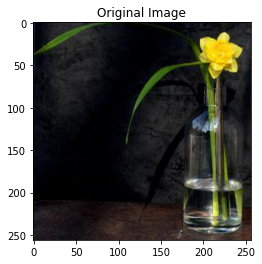

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


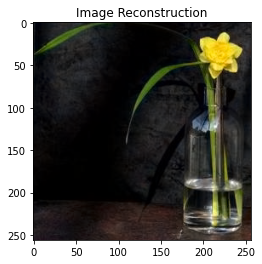

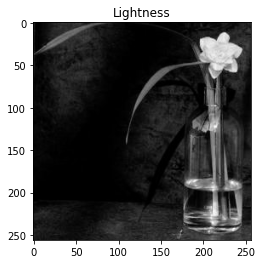

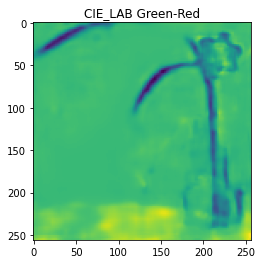

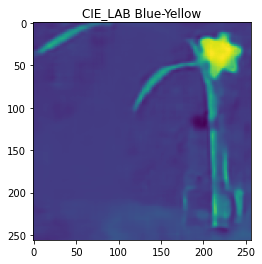

In [11]:
# Print Testing Sample
# Boat is test [3] 1221ish
# Giraffe is test [1]
# Vase is test [4]
image_number = [4]

if len(image_number)<1:
  image_number = [np.random.randint(0,len(output))]
L_eval, y_ab, orig_eval = output[image_number[0]]
# pdb.set_trace()
orig_eval = orig_eval[0,:,:,:]
L_eval = L_eval.squeeze(0).squeeze(0).unsqueeze(2)
y_ab = y_ab.squeeze(0).permute(1,2,0)
test_plot(L_eval, y_ab, orig_eval)

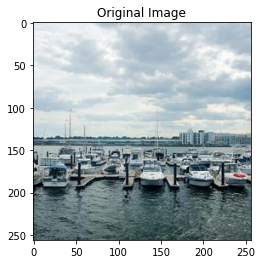

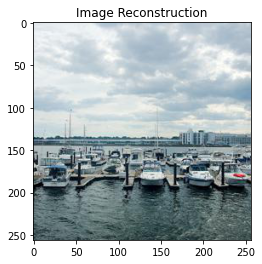

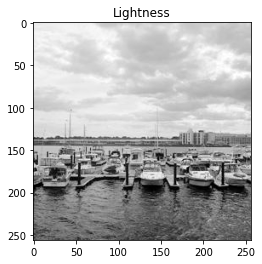

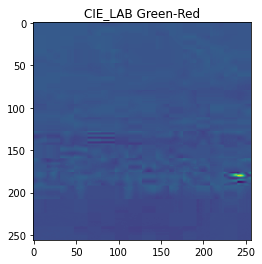

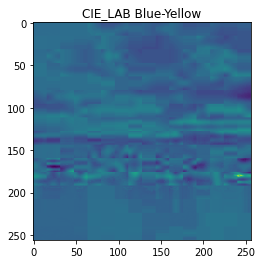

In [24]:
# Display image sample
Eval_Dataset = dataset
image_number = [0]
if len(image_number)<1:
  image_number = [np.random.randint(0,len(Eval_Dataset))]
L_eval, y_ab, orig_eval = Eval_Dataset[image_number[0]]
test_plot(L_eval, y_ab, orig_eval)